In [199]:
# Import packages
import os
import sys
import warnings
import inspect
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch
from scipy.interpolate import make_interp_spline

# Set directories
notebook_dir = os.getcwd()
base_dir = os.path.join(notebook_dir, '..')
data_dir = os.path.join(base_dir, 'data', 'processed')
raw_data_dir = os.path.join(base_dir, 'data', 'raw')
src_dir = os.path.join(base_dir, 'src')
graph_dir = os.path.join(base_dir, 'results', 'graphs')
sys.path.append(src_dir)

In [200]:
# Load yearly return data for ff6 and hxz
ff6_yearly_df = pd.read_csv(os.path.join(data_dir, 'ff6_yearly.csv'))
hxz_yearly_df = pd.read_csv(os.path.join(data_dir, 'hxz_yearly.csv'))
ff6_yearly_df.rename(columns={'Year': 'year'}, inplace=True)

In [201]:
# Load NYSE and S&P500 price data and format into yearly returns
NYSE_SP500 = pd.read_csv(os.path.join(data_dir, 'NYSE_SP500.csv'))
NYSE_SP500['Date'] = pd.to_datetime(NYSE_SP500['Date'])
NYSE_SP500['year'] = NYSE_SP500['Date'].dt.year
NYSE_SP500_yearly = NYSE_SP500.groupby('year').last().reset_index()
NYSE_SP500_yearly.drop('Date', axis=1, inplace=True)

NYSE_SP500_yearly['NYSE'] = NYSE_SP500_yearly['CloseNYSE'].pct_change() * 100
NYSE_SP500_yearly['SP500'] = NYSE_SP500_yearly['CloseSP500'].pct_change() * 100
NYSE_SP500_yearly.drop(['CloseNYSE', 'CloseSP500'], axis=1, inplace=True)
NYSE_SP500_yearly.drop(0, axis=0, inplace=True)

In [202]:
# Merge DataFrames
merged_yearly = NYSE_SP500_yearly.merge(ff6_yearly_df, on='year', how='left').merge(hxz_yearly_df, on='year', how='left')
merged_yearly.drop(['Mkt-RF', 'RF', 'R_MKT', 'R_F'], axis=1, inplace=True)
merged_yearly.rename(columns={'R_ME': 'ME', 'R_IA': 'IA', 'R_ROE': 'ROE', 'R_EG': 'EG'}, inplace=True)
merged_yearly.set_index('year', inplace=True)

In [203]:
merged_yearly_t = merged_yearly.T
merged_yearly_t

year,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
NYSE,-7.460122,27.120967,4.694064,7.855367,-3.141877,31.310362,19.055435,30.306146,16.553354,9.145656,...,4.220254,-6.419457,9.005646,15.844761,-11.198908,22.318917,4.397098,18.171204,-11.534643,10.988850
SP500,-6.559138,26.306703,4.464263,7.055156,-1.539291,34.110655,20.263666,31.008182,26.668589,19.526047,...,11.390634,-0.726600,9.535023,19.419966,-6.237260,28.878070,16.258923,26.892739,-19.442827,24.230501
MOM,18.310000,14.700000,3.430000,23.690000,3.210000,18.040000,6.390000,11.450000,23.090000,35.190000,...,1.020000,20.480000,-21.270000,4.630000,9.880000,-2.640000,7.750000,-2.400000,15.490000,-24.230000
SMB,-14.020000,15.810000,9.080000,6.260000,-2.330000,-8.120000,-2.860000,-6.330000,-28.030000,8.860000,...,-7.910000,-5.890000,9.310000,-6.160000,-5.090000,-6.160000,3.420000,-1.210000,-1.610000,-5.990000
HML,-10.030000,-14.720000,24.490000,16.960000,-0.890000,5.970000,8.670000,19.000000,-10.430000,-31.660000,...,-1.450000,-9.650000,22.710000,-13.570000,-9.670000,-10.460000,-46.670000,25.490000,25.810000,-13.570000
RMW,7.610000,11.610000,7.380000,-6.910000,5.820000,1.670000,15.550000,8.800000,3.560000,-28.040000,...,1.280000,1.070000,4.340000,4.850000,-1.380000,4.320000,-5.220000,26.690000,6.670000,5.930000
CMA,0.790000,-14.870000,7.320000,12.300000,3.800000,2.890000,0.860000,6.190000,-4.620000,-8.370000,...,-1.460000,-8.750000,9.970000,-11.490000,0.060000,-3.060000,-11.500000,11.980000,22.430000,-20.960000
ME,-12.216100,14.091000,6.538000,7.176600,1.178200,-6.886000,1.921500,-3.901400,-27.488100,8.168500,...,-7.547000,-5.552400,5.897000,-1.382300,-5.951300,-7.218100,-1.866800,4.702200,1.059900,-6.089200
IA,3.307100,-9.489700,8.400600,11.515300,5.198600,6.649400,4.647300,4.772500,-1.859900,-5.446700,...,0.030000,-6.938700,5.629000,-13.349400,-0.570300,-3.299100,-16.859600,12.194900,27.795200,-23.990300
ROE,15.713600,21.796300,9.383800,-0.335900,12.256000,10.595100,18.360300,10.154300,17.688700,-14.785200,...,4.547300,9.297200,-2.353600,10.998500,4.356300,2.457400,-13.876500,27.208900,6.784200,11.450100


In [204]:
dummy_row = pd.DataFrame(np.nan, index=['Factors Below'], columns=merged_yearly_t.columns)
# Adjust this based on where 'NYSE' and 'SP500' are in your DataFrame
part1 = merged_yearly_t.loc[:'SP500']
part2 = merged_yearly_t.loc['MOM':]
merged_heatmap = pd.concat([part1, dummy_row, part2])

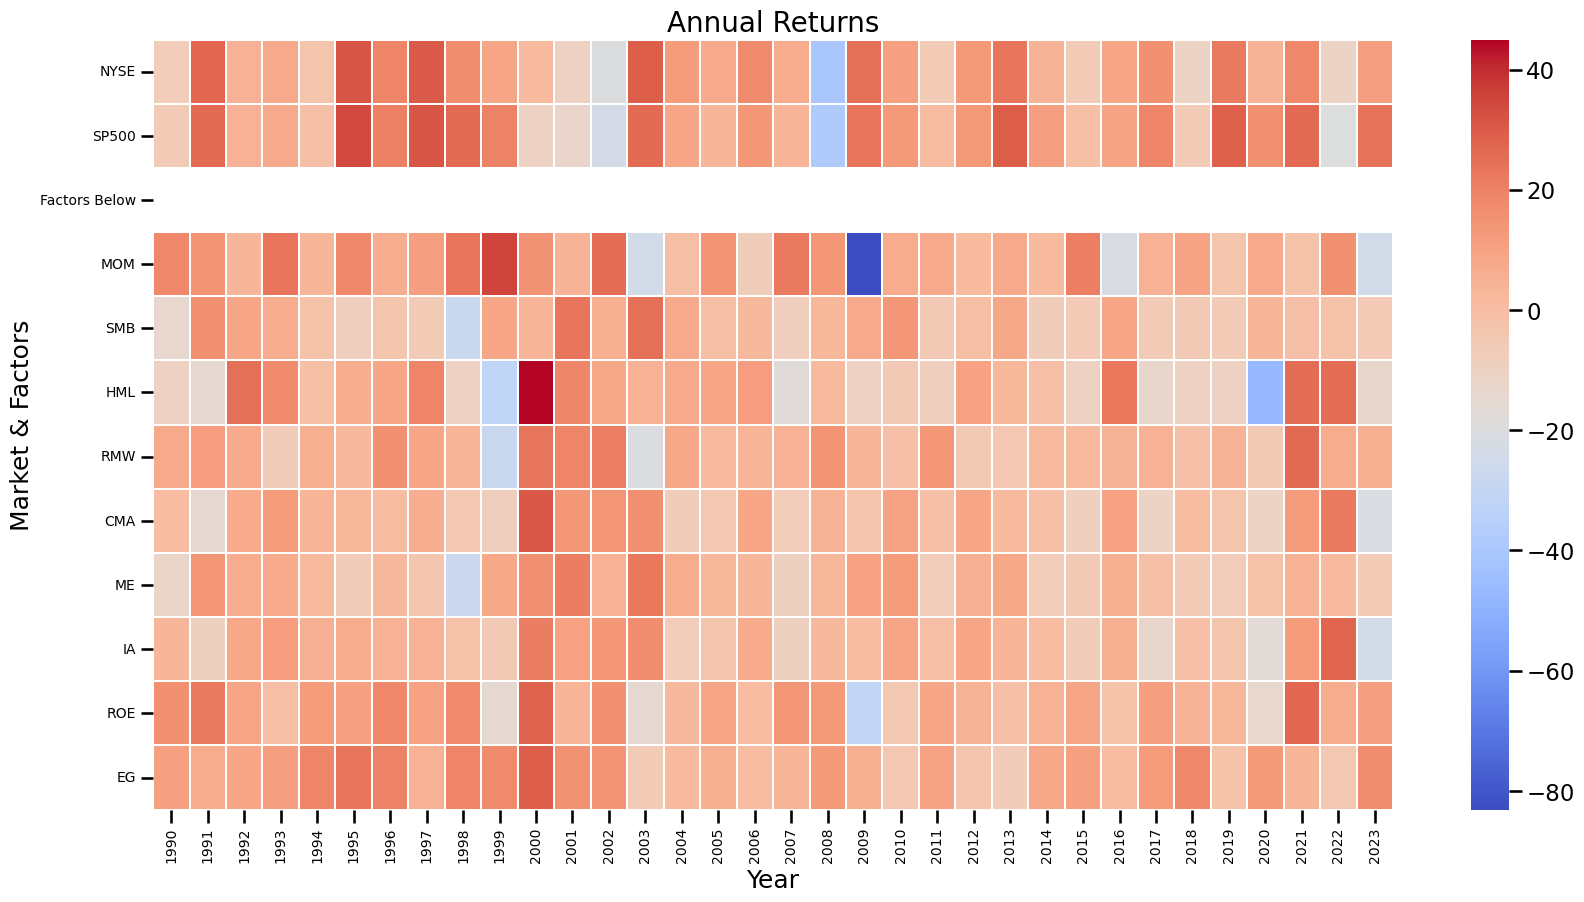

In [205]:
sns.set_context("talk")

# Create a heatmap with seaborn
plt.figure(figsize=(20, 10))  # Adjust the figure size as needed
heatmap = sns.heatmap(merged_heatmap, annot=False, fmt=".0f", cmap='coolwarm', linewidths=.1, annot_kws={"size": 15})

# Setting the title, x-label, and y-label
plt.title('Annual Returns', fontsize=20)
plt.xlabel('Year', fontsize=18)
plt.ylabel('Market & Factors', fontsize=18)

# Adjusting the x and y ticks font size if necessary
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Save the heatmap to a file with a higher DPI for better resolution
plt.savefig('heatmap_detailed.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

In [206]:
merged_yearly_t['AvgYearlyReturn'] = merged_yearly_t.mean(axis=1).round(2)
merged_yearly_t

year,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,AvgYearlyReturn
NYSE,-7.460122,27.120967,4.694064,7.855367,-3.141877,31.310362,19.055435,30.306146,16.553354,9.145656,...,-6.419457,9.005646,15.844761,-11.198908,22.318917,4.397098,18.171204,-11.534643,10.988850,7.64
SP500,-6.559138,26.306703,4.464263,7.055156,-1.539291,34.110655,20.263666,31.008182,26.668589,19.526047,...,-0.726600,9.535023,19.419966,-6.237260,28.878070,16.258923,26.892739,-19.442827,24.230501,9.45
MOM,18.310000,14.700000,3.430000,23.690000,3.210000,18.040000,6.390000,11.450000,23.090000,35.190000,...,20.480000,-21.270000,4.630000,9.880000,-2.640000,7.750000,-2.400000,15.490000,-24.230000,4.98
SMB,-14.020000,15.810000,9.080000,6.260000,-2.330000,-8.120000,-2.860000,-6.330000,-28.030000,8.860000,...,-5.890000,9.310000,-6.160000,-5.090000,-6.160000,3.420000,-1.210000,-1.610000,-5.990000,1.02
HML,-10.030000,-14.720000,24.490000,16.960000,-0.890000,5.970000,8.670000,19.000000,-10.430000,-31.660000,...,-9.650000,22.710000,-13.570000,-9.670000,-10.460000,-46.670000,25.490000,25.810000,-13.570000,1.61
RMW,7.610000,11.610000,7.380000,-6.910000,5.820000,1.670000,15.550000,8.800000,3.560000,-28.040000,...,1.070000,4.340000,4.850000,-1.380000,4.320000,-5.220000,26.690000,6.670000,5.930000,4.62
CMA,0.790000,-14.870000,7.320000,12.300000,3.800000,2.890000,0.860000,6.190000,-4.620000,-8.370000,...,-8.750000,9.970000,-11.490000,0.060000,-3.060000,-11.500000,11.980000,22.430000,-20.960000,2.28
ME,-12.216100,14.091000,6.538000,7.176600,1.178200,-6.886000,1.921500,-3.901400,-27.488100,8.168500,...,-5.552400,5.897000,-1.382300,-5.951300,-7.218100,-1.866800,4.702200,1.059900,-6.089200,1.85
IA,3.307100,-9.489700,8.400600,11.515300,5.198600,6.649400,4.647300,4.772500,-1.859900,-5.446700,...,-6.938700,5.629000,-13.349400,-0.570300,-3.299100,-16.859600,12.194900,27.795200,-23.990300,2.40
ROE,15.713600,21.796300,9.383800,-0.335900,12.256000,10.595100,18.360300,10.154300,17.688700,-14.785200,...,9.297200,-2.353600,10.998500,4.356300,2.457400,-13.876500,27.208900,6.784200,11.450100,6.14


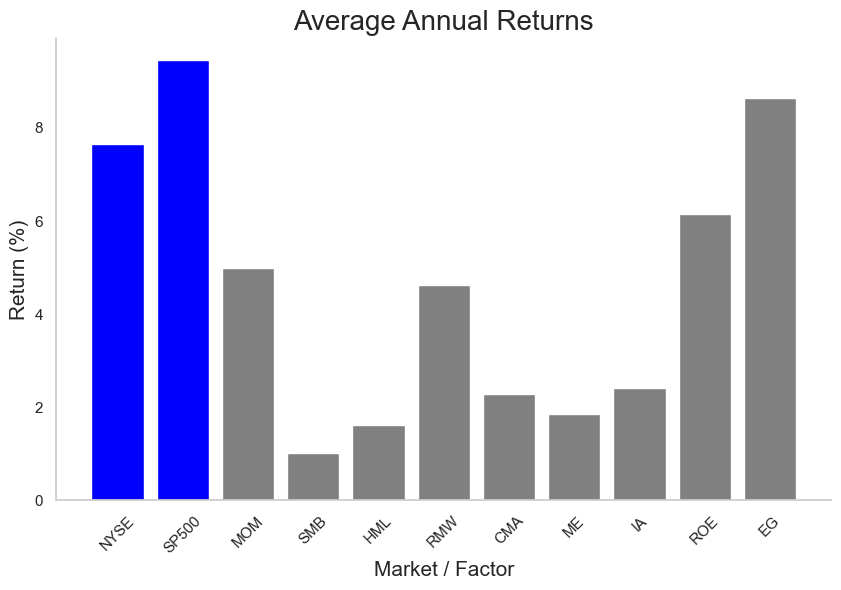

In [216]:
data = merged_yearly_t['AvgYearlyReturn']


colors = ['blue', 'blue'] + ['grey'] * (len(data) - 2) 

plt.figure(figsize=(10, 6))
bars = plt.bar(data.index, data.values, color=colors)

plt.title('Average Annual Returns', fontsize=20)
plt.xlabel('Market / Factor', fontsize=15)
plt.ylabel('Return (%)', fontsize=15)

plt.grid(False)

plt.xticks(rotation=45)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()